# ***Implementation of DINOv2-style Self-Supervised Learning Plastic Object Detection from Seashore using YOLOv11 backbone***

# Setup

In [1]:
!pip -q install ultralytics timm tqdm pillow 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.3 MB/s eta 0:00:00


In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Dataset Path

In [3]:

BASE  = Path("/kaggle/input/plastic-coco/plastic_coco")
WORK  = Path("/kaggle/working/plastic_coco_ssl_yolov11_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_plastic_coco.yaml"
SSL_W = WORK / "backbone_ssl_v11_dinov2.pt"   
WORK.mkdir(parents=True, exist_ok=True)

# COCO -> YOLO conversion (once)

In [4]:
def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x + bw / 2) / w, (y + bh / 2) / h, bw / w, bh / h

def convert(split, img_dir, ann_json):
    out_im, out_lb = SPLIT / split / "images", SPLIT / split / "labels"
    out_im.mkdir(parents=True, exist_ok=True)
    out_lb.mkdir(parents=True, exist_ok=True)

    coco = json.load(open(ann_json))
    id2 = {im["id"]: im for im in coco["images"]}

    # write labels
    for ann in coco["annotations"]:
        im = id2[ann["image_id"]]
        yb = coco2yolo(ann["bbox"], im["width"], im["height"])
        with open(out_lb / f"{Path(im['file_name']).stem}.txt", "a") as f:
            f.write(f"{ann['category_id']-1} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # copy images
    for im in coco["images"]:
        src = Path(img_dir) / im["file_name"]
        dst = out_im / im["file_name"]
        if src.exists():
            shutil.copy(src, dst)
        else:
            print(f"Missing image: {src}")

# ========================
# Run Conversion
# ========================
if not DATA.exists():
    print("➤ Converting COCO → YOLO …")

    convert("train", BASE / "images" / "train", BASE / "annotation" / "train.json")
    convert("valid", BASE / "images" / "val",   BASE / "annotation" / "val.json")
    convert("test",  BASE / "images" / "test",  BASE / "annotation" / "test.json")

    # class names
    categories = json.load(open(BASE / "annotation" / "train.json"))["categories"]
    names = [c["name"] for c in sorted(categories, key=lambda x: x["id"])]

    DATA.write_text(yaml.dump({
        "path": str(SPLIT),
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "nc": len(names),
        "names": names
    }))
    print("✓ YOLO split ready at", SPLIT)
else:
    print("YOLO split already exists")
    

➤ Converting COCO → YOLO …
✓ YOLO split ready at /kaggle/working/plastic_coco_ssl_yolov11_dinov2/yolo_split


# Multi-crop Dataset (DINOv2-style: 2 global + 8 local)

In [5]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

# Build YOLOv11s model and grab backbone (no fallback) 
# Robust encoder that handles different backbone return types/shapes

In [6]:
detector = YOLO("yolo11s.pt")   # load pretrained YOLOv11s
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolo11s.pt").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters():
    p.requires_grad = False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


# DINOv2-style Heads and Loss

In [7]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


# DINOv2-style SSL pretraining

In [8]:
EPOCHS     = 50       
BATCH      = 16
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.996
N_LOCAL    = 8
NUM_WORKERS= 0

train_losses = []

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print("\n DINOv2-style pretraining on YOLOv11 backbone …")
    ds = MultiCropDINO([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        avg_loss = ep_loss / steps_per_epoch
        train_losses.append(avg_loss)
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv11 backbone →", SSL_W)



 DINOv2-style pretraining on YOLOv11 backbone …


/tmp/ipykernel_19/3836504422.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 01: loss=6.8756


SSL Ep 2/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 02: loss=5.3432


SSL Ep 3/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 03: loss=5.1772


SSL Ep 4/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 04: loss=5.4718


SSL Ep 5/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 05: loss=5.9686


SSL Ep 6/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 06: loss=6.1084


SSL Ep 7/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 07: loss=5.9538


SSL Ep 8/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 08: loss=5.7036


SSL Ep 9/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 09: loss=5.6402


SSL Ep 10/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 10: loss=5.4021


SSL Ep 11/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 11: loss=5.3526


SSL Ep 12/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 12: loss=5.1870


SSL Ep 13/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 13: loss=5.0597


SSL Ep 14/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 14: loss=4.9478


SSL Ep 15/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 15: loss=4.9095


SSL Ep 16/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 16: loss=4.7760


SSL Ep 17/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 17: loss=4.7080


SSL Ep 18/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 18: loss=4.6847


SSL Ep 19/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 19: loss=4.6499


SSL Ep 20/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 20: loss=4.6302


SSL Ep 21/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 21: loss=4.5578


SSL Ep 22/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 22: loss=4.5299


SSL Ep 23/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 23: loss=4.5290


SSL Ep 24/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 24: loss=4.5450


SSL Ep 25/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 25: loss=4.5206


SSL Ep 26/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 26: loss=4.5358


SSL Ep 27/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 27: loss=4.5231


SSL Ep 28/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 28: loss=4.5082


SSL Ep 29/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 29: loss=4.5211


SSL Ep 30/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 30: loss=4.5300


SSL Ep 31/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 31: loss=4.5282


SSL Ep 32/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 32: loss=4.5180


SSL Ep 33/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 33: loss=4.4958


SSL Ep 34/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 34: loss=4.5003


SSL Ep 35/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 35: loss=4.4903


SSL Ep 36/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 36: loss=4.4765


SSL Ep 37/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 37: loss=4.4586


SSL Ep 38/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 38: loss=4.4511


SSL Ep 39/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 39: loss=4.4407


SSL Ep 40/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 40: loss=4.4413


SSL Ep 41/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 41: loss=4.4392


SSL Ep 42/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 42: loss=4.4152


SSL Ep 43/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 43: loss=4.4065


SSL Ep 44/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 44: loss=4.3869


SSL Ep 45/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 45: loss=4.4064


SSL Ep 46/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 46: loss=4.4081


SSL Ep 47/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 47: loss=4.4148


SSL Ep 48/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 48: loss=4.4053


SSL Ep 49/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 49: loss=4.4059


SSL Ep 50/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 50: loss=4.4137
✓ Saved SSL YOLOv11 backbone → /kaggle/working/plastic_coco_ssl_yolov11_dinov2/backbone_ssl_v11_dinov2.pt


# Loss Curve

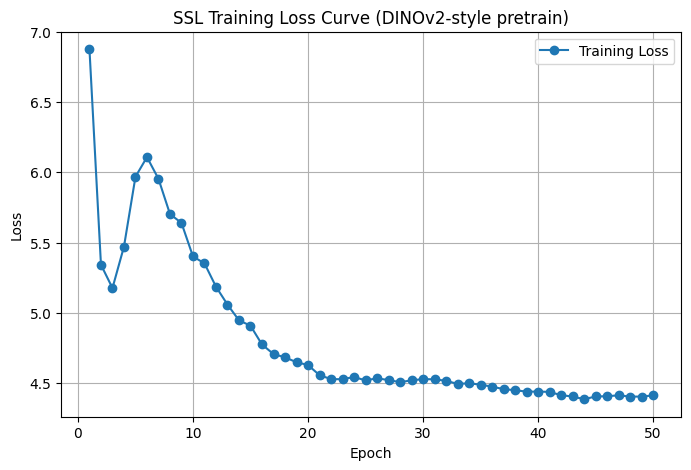

In [9]:
# =============================
# Plot training loss curves
# =============================

plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, marker="o", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SSL Training Loss Curve (DINOv2-style pretrain)")
plt.legend()
plt.grid(True)
plt.show()

#  Detector fine-tuning (YOLOv11s, init with SSL backbone)

In [10]:
det = YOLO("yolo11s.pt")  
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(
    data=str(DATA),
    epochs=50,                   
    imgsz=640,
    batch=8,
    optimizer="AdamW",            
    lr0=5e-4,                     
    lrf=1e-5,
    weight_decay=0.05,
    cos_lr=True,                  
    mosaic=1.0,
    mixup=0.2,                    
    copy_paste=0.2,               
    auto_augment="randaugment",
    close_mosaic=15,              
    dropout=0.1,                  
    patience=30,
    save_period=5,
    device=0 if device=="cuda" else "cpu",
    project=str(WORK),
    name="ssl_yolov11s_dinov2",
    verbose=True,
)


Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/plastic_coco_ssl_yolov11_dinov2/data_plastic_coco.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=1e-05, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolov11s_dinov2, nbs=64, nms=False, opset=None, op

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4305.5±898.1 MB/s, size: 776.5 KB)


train: Scanning /kaggle/working/plastic_coco_ssl_yolov11_dinov2/yolo_split/train/labels... 2223 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2226/2226 [00:17<00:00, 130.58it/s]

train: New cache created: /kaggle/working/plastic_coco_ssl_yolov11_dinov2/yolo_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1005.6±867.3 MB/s, size: 694.7 KB)


val: Scanning /kaggle/working/plastic_coco_ssl_yolov11_dinov2/yolo_split/valid/labels... 742 images, 0 backgrounds, 0 corrupt: 100%|██████████| 742/742 [00:05<00:00, 132.08it/s]

val: New cache created: /kaggle/working/plastic_coco_ssl_yolov11_dinov2/yolo_split/valid/labels.cache


Plotting labels to /kaggle/working/plastic_coco_ssl_yolov11_dinov2/ssl_yolov11s_dinov2/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.05), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/plastic_coco_ssl_yolov11_dinov2/ssl_yolov11s_dinov2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.11G      2.096      1.782      1.125        132        640: 100%|██████████| 279/279 [01:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  5.22it/s]


                   all        742      23015      0.453      0.345       0.32      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.68G      2.023      1.572      1.084        173        640: 100%|██████████| 279/279 [00:58<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


                   all        742      23015      0.459      0.358      0.339      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.72G      1.997      1.536      1.076         88        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.70it/s]


                   all        742      23015      0.451      0.383      0.338      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.76G      1.999      1.568      1.078        274        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.75it/s]


                   all        742      23015      0.457      0.366      0.342      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       5.8G      1.985      1.499      1.076        233        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.96it/s]


                   all        742      23015      0.475      0.382      0.368      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.84G      1.964       1.48      1.069         97        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


                   all        742      23015      0.494      0.377      0.369      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.87G      1.959       1.47      1.061         61        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.91it/s]


                   all        742      23015      0.501      0.387      0.382      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.92G      1.961      1.466       1.06        158        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.94it/s]


                   all        742      23015      0.494      0.381      0.373      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.96G       1.95      1.455      1.067        105        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.85it/s]


                   all        742      23015      0.502      0.391      0.384      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         6G      1.916      1.418      1.055        157        640: 100%|██████████| 279/279 [00:57<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


                   all        742      23015      0.499      0.394      0.382      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.04G      1.931      1.435      1.061        412        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.90it/s]


                   all        742      23015      0.499      0.387      0.372      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.08G      1.917      1.422      1.055        124        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.89it/s]


                   all        742      23015      0.514      0.398      0.393      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.12G      1.918      1.408      1.046        168        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


                   all        742      23015      0.517      0.402      0.398      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.16G      1.888      1.396      1.045         63        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.88it/s]


                   all        742      23015      0.519      0.399      0.391      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.18G      1.895      1.377      1.044         66        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.08it/s]


                   all        742      23015      0.521        0.4      0.403      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.24G      1.886      1.395      1.049         93        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


                   all        742      23015      0.521      0.401      0.403      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.28G      1.893      1.378      1.043         96        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.97it/s]


                   all        742      23015      0.521      0.411       0.41      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.32G      1.868      1.354       1.04        154        640: 100%|██████████| 279/279 [00:57<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.90it/s]


                   all        742      23015      0.515      0.406      0.399       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.36G      1.865      1.363       1.04         82        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.93it/s]


                   all        742      23015      0.521      0.406      0.406       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       6.4G      1.865      1.349      1.036        158        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


                   all        742      23015      0.534      0.407      0.414      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.44G      1.859      1.341      1.032         31        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


                   all        742      23015      0.538      0.403       0.41      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.48G      1.834      1.341      1.031        182        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.79it/s]


                   all        742      23015      0.514      0.417       0.41       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       6.5G      1.827       1.32      1.025         27        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.81it/s]


                   all        742      23015      0.521      0.408      0.407      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.56G      1.835      1.313      1.024        261        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.12it/s]


                   all        742      23015      0.526      0.407      0.411      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       6.6G      1.834      1.308      1.025         50        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.99it/s]


                   all        742      23015      0.535      0.417      0.419      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.33G      1.813      1.304      1.028         91        640: 100%|██████████| 279/279 [00:58<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.05it/s]


                   all        742      23015      0.536      0.411      0.419      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.37G      1.812      1.285       1.02         28        640: 100%|██████████| 279/279 [00:58<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


                   all        742      23015      0.532      0.422      0.426      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.41G      1.796      1.271      1.022        323        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.07it/s]


                   all        742      23015      0.535      0.419      0.422      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.45G      1.793      1.286      1.016          9        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


                   all        742      23015      0.538      0.418      0.424      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.49G      1.792      1.268      1.012         53        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.97it/s]


                   all        742      23015      0.543       0.42      0.428      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.51G      1.777      1.249       1.01         44        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.96it/s]


                   all        742      23015      0.536      0.422      0.425      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.57G      1.788      1.245      1.012        121        640: 100%|██████████| 279/279 [00:57<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


                   all        742      23015      0.537      0.415      0.426      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.61G      1.766       1.24      1.012         68        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.94it/s]


                   all        742      23015      0.544      0.422      0.432      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.65G      1.743      1.211      1.005         66        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.07it/s]


                   all        742      23015      0.539      0.425      0.431      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.69G      1.758      1.235       1.01         51        640: 100%|██████████| 279/279 [00:57<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.97it/s]


                   all        742      23015      0.541      0.427      0.429      0.198
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.73G      1.682      1.206     0.9876         74        640: 100%|██████████| 279/279 [00:56<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.91it/s]


                   all        742      23015      0.531      0.426      0.426      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.77G      1.673      1.169     0.9774         60        640: 100%|██████████| 279/279 [00:55<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.10it/s]


                   all        742      23015      0.541      0.429      0.432      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.81G      1.669      1.158     0.9799         24        640: 100%|██████████| 279/279 [00:55<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.03it/s]


                   all        742      23015      0.536      0.424      0.428      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.83G      1.658      1.147     0.9758         92        640: 100%|██████████| 279/279 [00:55<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.05it/s]


                   all        742      23015      0.539      0.429      0.432        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.89G      1.657      1.141     0.9745         72        640: 100%|██████████| 279/279 [00:55<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


                   all        742      23015      0.548      0.428      0.436        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.93G      1.648      1.131     0.9699         18        640: 100%|██████████| 279/279 [00:55<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


                   all        742      23015      0.548       0.43      0.436        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.97G      1.646      1.121     0.9734         90        640: 100%|██████████| 279/279 [00:55<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.98it/s]


                   all        742      23015      0.545       0.43      0.437      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.49G      1.643      1.114     0.9751         27        640: 100%|██████████| 279/279 [00:55<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.02it/s]


                   all        742      23015      0.546      0.431      0.436      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.49G      1.631       1.11     0.9687         39        640: 100%|██████████| 279/279 [00:56<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


                   all        742      23015      0.548      0.428      0.435      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.49G      1.635      1.106     0.9736         12        640: 100%|██████████| 279/279 [00:56<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.04it/s]


                   all        742      23015      0.543      0.429      0.437      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.49G      1.636      1.103      0.971        152        640: 100%|██████████| 279/279 [00:56<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  5.94it/s]


                   all        742      23015      0.545      0.429      0.436      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.49G      1.621      1.103     0.9675         23        640: 100%|██████████| 279/279 [00:55<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.15it/s]


                   all        742      23015      0.548      0.429      0.437      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.49G      1.624      1.105     0.9686         12        640: 100%|██████████| 279/279 [00:55<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.12it/s]


                   all        742      23015      0.549      0.425      0.436      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.49G      1.632      1.099     0.9735         43        640: 100%|██████████| 279/279 [00:56<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.01it/s]


                   all        742      23015      0.547      0.429      0.436      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.49G      1.621      1.094     0.9727         93        640: 100%|██████████| 279/279 [00:55<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.05it/s]


                   all        742      23015      0.549      0.426      0.436      0.202

50 epochs completed in 0.918 hours.
Optimizer stripped from /kaggle/working/plastic_coco_ssl_yolov11_dinov2/ssl_yolov11s_dinov2/weights/last.pt, 19.2MB
Optimizer stripped from /kaggle/working/plastic_coco_ssl_yolov11_dinov2/ssl_yolov11s_dinov2/weights/best.pt, 19.2MB

Validating /kaggle/working/plastic_coco_ssl_yolov11_dinov2/ssl_yolov11s_dinov2/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:13<00:00,  3.48it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015      0.547       0.43      0.436      0.202
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /kaggle/working/plastic_coco_ssl_yolov11_dinov2/ssl_yolov11s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a1919a0ebd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Evaluate and visualize one image

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2899.6±394.8 MB/s, size: 513.2 KB)


val: Scanning /kaggle/working/plastic_coco_ssl_yolov11_dinov2/yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100%|██████████| 742/742 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:12<00:00,  7.62it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015      0.548      0.433      0.438      0.204
Speed: 0.3ms preprocess, 5.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.5481
 Recall    (mR) : 0.4327
 mAP@0.50      : 0.4376
 mAP@0.50-0.95 : 0.2038


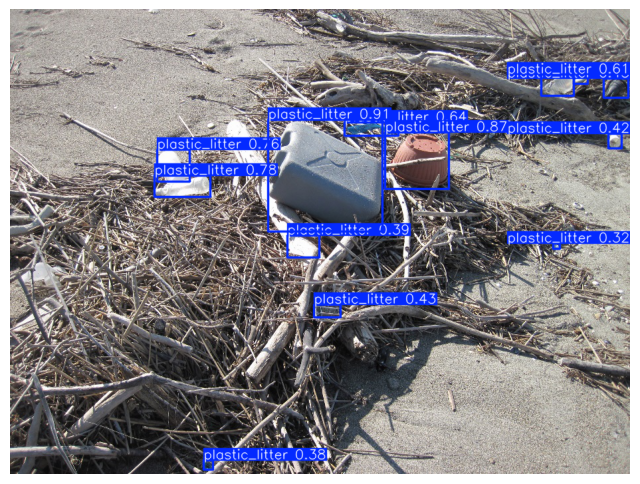

In [11]:
best_pt = WORK / "ssl_yolov11s_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=8,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")

# PCA of SSL-pretrained YOLOv11 backbone features (robust encoder)

PCA Feature matrix: (1000, 32)


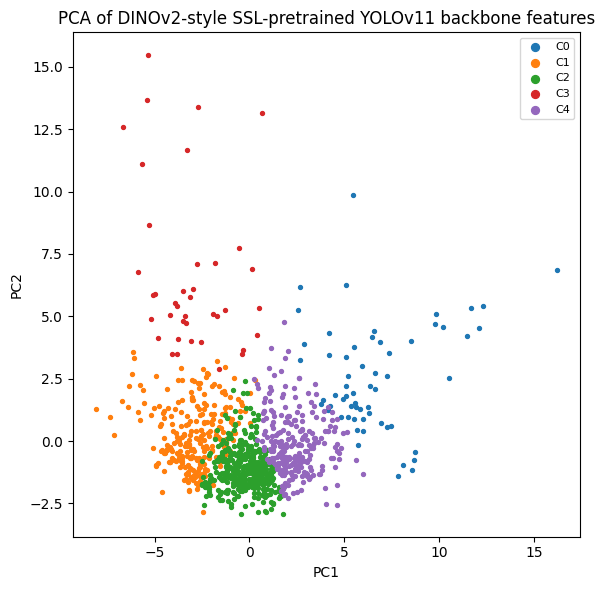

In [12]:
det_pca = YOLO("yolo11s.pt")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# sample images for PCA
IMG_DIRS = [SPLIT/"train/images", SPLIT/"valid/images"]
files=[]
for d in IMG_DIRS:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)

k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

plt.figure(figsize=(6,6))
for i in range(k):
    m = (lab==i)
    plt.scatter(xy[m,0], xy[m,1], s=8, label=f"C{i}")
plt.title("PCA of DINOv2-style SSL-pretrained YOLOv11 backbone features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


# Save YOLOv11 Model Result 

In [13]:
metrics = det.val(data=str(DATA), split="val")

results_dict = {
    "Method": "YOLOv11-SSL",
    "Backbone": "DINOv2",
    "Parameters (M)": round(sum(p.numel() for p in det.model.parameters())/1e6, 2),
    "Precision": metrics.results_dict["metrics/precision(B)"],
    "Recall": metrics.results_dict["metrics/recall(B)"],
    "F1": (2 * metrics.results_dict["metrics/precision(B)"] * metrics.results_dict["metrics/recall(B)"]) /
          (metrics.results_dict["metrics/precision(B)"] + metrics.results_dict["metrics/recall(B)"] + 1e-9),
    "mAP@0.5": metrics.results_dict["metrics/mAP50(B)"],
    "mAP@0.95": metrics.results_dict["metrics/mAP50-95(B)"],
}

with open("results_yolov11.json", "w") as f:
    json.dump(results_dict, f, indent=4)


Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3075.1±1077.0 MB/s, size: 2153.7 KB)


val: Scanning /kaggle/working/plastic_coco_ssl_yolov11_dinov2/yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100%|██████████| 742/742 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:12<00:00,  7.72it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015      0.548      0.433      0.438      0.204
Speed: 0.3ms preprocess, 6.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/plastic_coco_ssl_yolov11_dinov2/ssl_yolov11s_dinov22
